# Setup

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as tdist

In [2]:
def get_msl_log_likelihood(X, mu, sigma, gamma, normalize=True):
    sigma_inv = torch.inverse(sigma)
    alpha = torch.sqrt(1 + torch.einsum("i,ij,j", gamma, sigma_inv, gamma))
    diff = X - mu[None]
    root_exp = torch.einsum("ni,ij,nj->n", diff, sigma_inv, diff).sqrt()
    add_exp = torch.einsum("ni,ij,j-> n", diff, sigma_inv, gamma)

    constants = 0.5 * torch.logdet(sigma_inv) - torch.log(alpha)
    if normalize:
        dim = torch.as_tensor(X.shape[1])
        dim_norm = math.log(2) * dim + math.log(math.pi) * ((dim - 1) / 2) + torch.lgamma((dim + 1) / 2)
        constants = constants - dim_norm
    log_prob = constants[None] - alpha * root_exp + add_exp
    return log_prob


def sample_msl(num_samples, mu, sigma, gamma):
    dim = mu.shape[0]
    (alpha, beta) = ((dim + 1) / 2, 1 / 2)
    root_sigma = torch.linalg.cholesky(sigma)
    V = tdist.InverseGamma(alpha, beta).rsample(torch.as_tensor([num_samples]))[:, None]
    Z = torch.randn([num_samples, dim])
    X = mu[None] + gamma[None] / V + torch.einsum("ij,nj->ni", root_sigma, Z) / V.sqrt()
    return X


def get_covariance(chol_params):
    diagonals = torch.nn.functional.softplus(torch.diagonal(chol_params, 0, -2, -1)) + 1e-4
    chol = torch.diag_embed(diagonals) + torch.tril(chol_params, -1)
    cov = chol @ chol.T
    return cov


def get_2d_densities(X, num_bins, bin_range):
    num_samples = X.shape[0]
    (counts, x_edges, y_edges) = np.histogram2d(X[:, 0], X[:, 1], num_bins, range=bin_range)
    density = counts / num_samples / (x_edges[1] - x_edges[0]) ** 2
    x_grid = (x_edges[:-1] + x_edges[1:]) / 2
    y_grid = (y_edges[:-1] + y_edges[1:]) / 2
    (x_coords, y_coords) = np.meshgrid(x_grid, y_grid, indexing="ij")
    return (density, x_coords, y_coords)

# 1D Sanity Check

In [3]:
mu = torch.as_tensor([0.0])
sigma = torch.as_tensor([[2.0]])
gamma = torch.as_tensor([1.0])
X = sample_msl(5000000, mu, sigma, gamma)

In [4]:
grid = torch.linspace(-20, 20, 10000)[:, None]
probs = torch.exp(get_msl_log_likelihood(grid, mu, sigma, gamma))

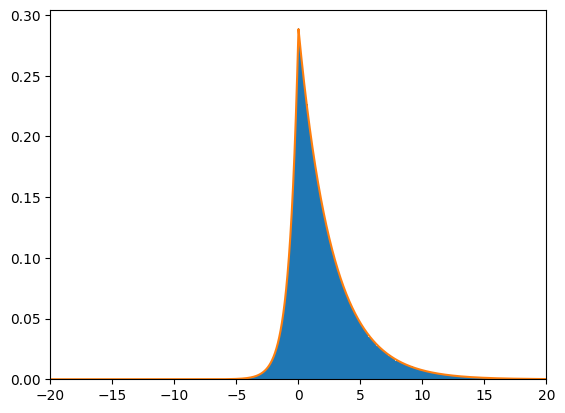

In [5]:
plt.hist(X, 5000, density=True)
plt.plot(grid, probs)
plt.xlim(-20, 20)
plt.show()

## 2D Sanity Check

In [6]:
num_samples = 50000000

mu = torch.as_tensor([1.0, 1.0])
sigma = get_covariance(torch.ones([2, 2]))
gamma = torch.as_tensor([2.0, 2.0])

X = sample_msl(num_samples, mu, sigma, gamma)
(density, x_coords, y_coords) = get_2d_densities(X, 500, bin_range=[[-5, 15], [-5, 15]])

In [7]:
coords = torch.from_numpy(np.stack([x_coords, y_coords], -1))
flat_coords = coords.reshape(-1, 2)
probs = torch.exp(get_msl_log_likelihood(flat_coords.float(), mu, sigma, gamma)).reshape(coords.shape[:2])

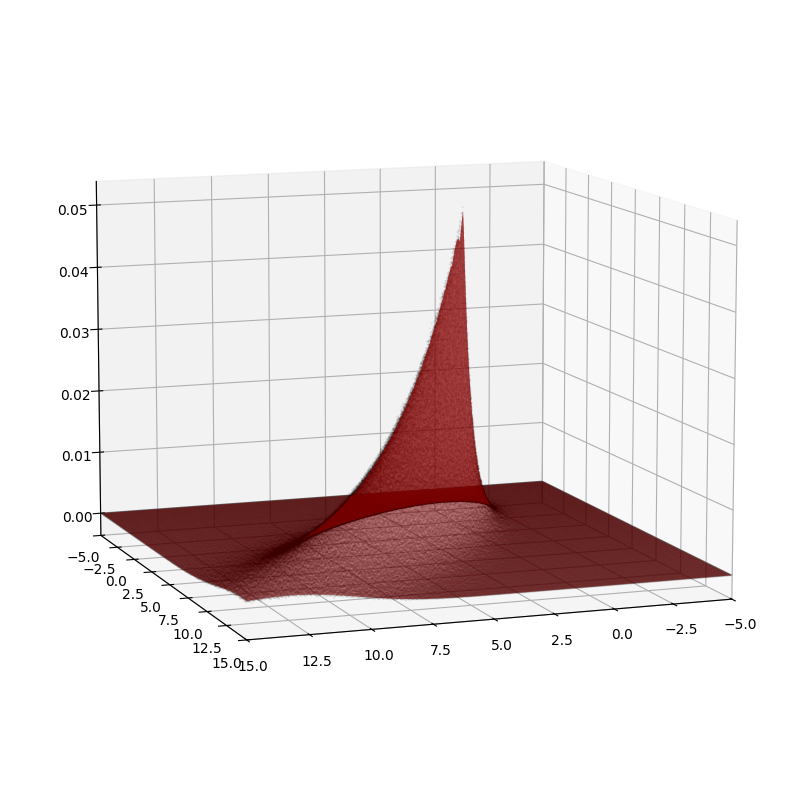

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(flat_coords[:, 0], flat_coords[:, 1], density.reshape(-1), s=0.1, alpha=0.1, c="black")
ax.plot_surface(coords[..., 0], coords[..., 1], probs, color="red", alpha=0.5)
ax.set_xlim3d(-5, 15)
ax.set_ylim3d(-5, 15)
ax.view_init(elev=10, azim=70)
plt.show()

# Optimization

In [9]:
num_samples = 500000
dim = 2
mu = torch.zeros([dim]) + 3
sigma = get_covariance(torch.ones([dim, dim]))
gamma = torch.ones([dim]) * 2
X = sample_msl(num_samples, mu, sigma, gamma)

In [10]:
mu_params = torch.nn.Parameter(torch.zeros([dim]))
gamma_params = torch.nn.Parameter(torch.ones([dim]))
chol_params = torch.nn.Parameter(torch.eye(dim))

optim = torch.optim.Adam([mu_params, gamma_params, chol_params])

In [11]:
(mu_0, gamma_0, sigma_0) = (mu_params.clone(), gamma_params.clone(), get_covariance(chol_params))
num_epochs = 10000
try:  # Training can be gracefully ended early by interrupting the cell execution
    for epoch in range(num_epochs):
        optim.zero_grad()
        loss = -get_msl_log_likelihood(X, mu_params, get_covariance(chol_params), gamma_params, normalize=False).mean()
        loss.backward()
        optim.step()
        print(f"Epoch {epoch + 1}/{num_epochs} -- {loss:.4f}            ", end="\r")
except KeyboardInterrupt:
    pass
(mu_1, gamma_1, sigma_1) = (mu_params.clone(), gamma_params.clone(), get_covariance(chol_params))

In [12]:
num_bins = 500
grid_range = [[-5, 15], [-10, 10]]

(x_grid, y_grid) = (torch.linspace(*grid_range[0], num_bins), torch.linspace(*grid_range[1], num_bins))
coords = torch.stack(torch.meshgrid(x_grid, y_grid, indexing="ij"), -1)
flat_coords = coords.reshape(-1, 2)

with torch.no_grad():
    probs_true = torch.exp(get_msl_log_likelihood(flat_coords.float(), mu, sigma, gamma)).reshape(coords.shape[:2])
    probs_0 = torch.exp(get_msl_log_likelihood(flat_coords.float(), mu_0, sigma_0, gamma_0)).reshape(coords.shape[:2])
    probs_1 = torch.exp(get_msl_log_likelihood(flat_coords.float(), mu_1, sigma_1, gamma_1)).reshape(coords.shape[:2])

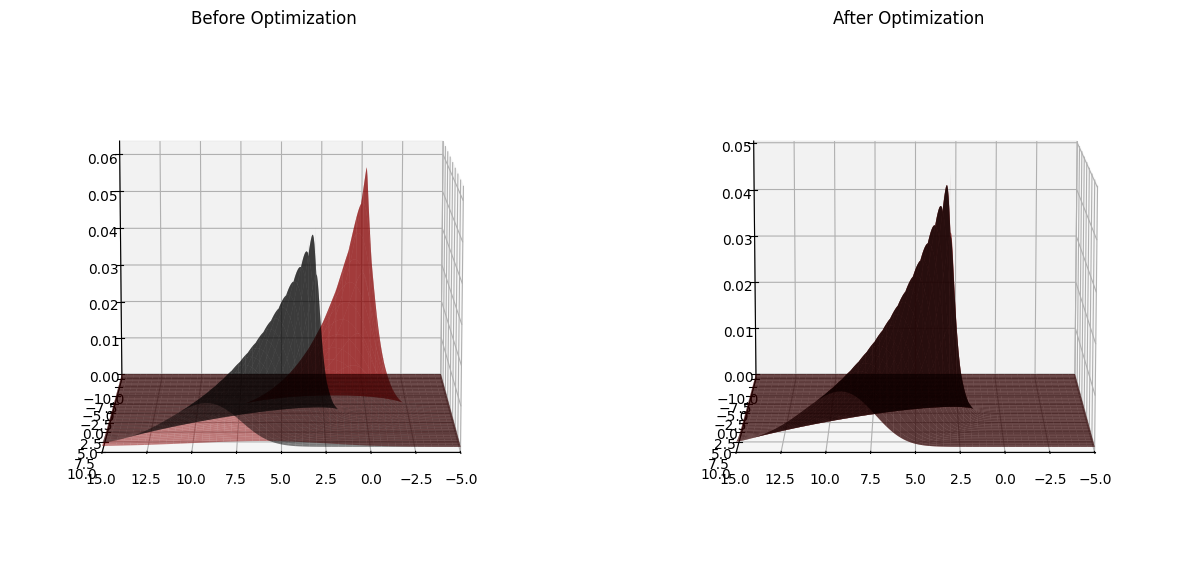

In [13]:
fig = plt.figure(figsize=(15, 15))
ax_0 = fig.add_subplot(1, 2, 1, projection="3d")
ax_1 = fig.add_subplot(1, 2, 2, projection="3d")

ax.plot_surface(coords[..., 0], coords[..., 1], probs, alpha=0.5)

ax_0.plot_surface(coords[..., 0], coords[..., 1], probs_true, color="black", alpha=0.5)
ax_0.plot_surface(coords[..., 0], coords[..., 1], probs_0, color="red", alpha=0.5)
ax_1.plot_surface(coords[..., 0], coords[..., 1], probs_true, color="black", alpha=0.5)
ax_1.plot_surface(coords[..., 0], coords[..., 1], probs_1, color="red", alpha=0.5)

ax_0.set_xlim3d(*grid_range[0])
ax_0.set_ylim3d(*grid_range[1])
ax_1.set_xlim3d(*grid_range[0])
ax_1.set_ylim3d(*grid_range[1])

ax_0.view_init(elev=10, azim=90)
ax_1.view_init(elev=10, azim=90)

ax_0.set_title("Before Optimization")
ax_1.set_title("After Optimization")

plt.show()